In [46]:
import librosa.effects
import numpy as np
import pandas as pd
import soundfile as sf

import os

from ipywidgets import Audio
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import librosa

In [86]:
INFERENCE_ROOT = "/home/kwatchar3/Documents/data/moisesdb/inference-o/vdb"
GROUND_TRUTH_ROOT = "/home/kwatchar3/Documents/data/moisesdb"

In [15]:
test_files = os.listdir(os.path.join(INFERENCE_ROOT, "audio"))

In [16]:
gt_files = os.listdir(os.path.join(GROUND_TRUTH_ROOT, "npy2"))

In [39]:
def merge_short_intervals(intervals, max_skip_seconds=0.5, fs=44100):

    # min_duration_samples = int(min_duration_seconds * fs)
    max_skip_samples = int(max_skip_seconds * fs)

    merged_intervals = []

    if len(intervals) == 0:
        return merged_intervals

    n_intervals = len(intervals)

    curr_start = intervals[0][0]
    curr_end = intervals[0][1]

    for i in range(1, n_intervals):
        start, end = intervals[i]

        if start - curr_end <= max_skip_samples:
            curr_end = end
        else:
            merged_intervals.append((curr_start, curr_end))
            curr_start = start
            curr_end = end

    merged_intervals.append((curr_start, curr_end))

    return merged_intervals




In [65]:
def snr(gt, est):
    return 10 * np.log10(np.sum(np.square(gt)) / np.sum(np.square(gt - est)))

In [69]:
DISPLAY_INTERVALS = False

df = []

for song in tqdm(test_files):
    song_name = song.split(".")[0]

    stems = os.listdir(os.path.join(INFERENCE_ROOT, "audio", song))
    stems = [s.replace(".wav", "") for s in stems]

    print(f"Processing {song_name}...")

    for stem in stems:
        audio = np.load(os.path.join(GROUND_TRUTH_ROOT, "npy2", song_name, f"{stem}.npy"), mmap_mode="r")
        sr = 44100

        rms = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512).max(axis=0)[0]
        dbrms = librosa.amplitude_to_db(rms, ref=1.0)
        # print(dbrms.shape)

        nonsilent = librosa.effects.split(audio, top_db=60,
                                          ref=1.0,
                                          frame_length=2048,
                                          hop_length=512)

        nonsilent = merge_short_intervals(nonsilent, max_skip_seconds=0.5, fs=sr)

        if DISPLAY_INTERVALS:
            f, ax = plt.subplots(1, 1, figsize=(20, 5))

            t = librosa.frames_to_time(np.arange(len(dbrms)), sr=sr, hop_length=512)
            ax.plot(t, dbrms)

            for interval in nonsilent:
                ax.axvspan(interval[0]/sr, interval[1]/sr, color='r', alpha=0.5)

            plt.title(f"{song_name} - {stem}")

            plt.show()

        audio_est, _ = sf.read(os.path.join(INFERENCE_ROOT, "audio", song, f"{stem}.wav"))
        audio_est = audio_est.T

        gt_nonsilent = np.concatenate([audio[:, start:end] for start, end in nonsilent], axis=-1)
        est_nonsilent = np.concatenate([audio_est[:, start:end] for start, end in nonsilent], axis=-1)

        snr_full = snr(audio, audio_est)
        snr_nonsilent = snr(gt_nonsilent, est_nonsilent)

        df.append({
            "song": song_name,
            "stem": stem,
            "snr_full": snr_full,
            "snr_nonsilent": snr_nonsilent
        })

        print(f"{stem} - SNR Full: {snr_full:-2.3f} - SNR Non-silent: {snr_nonsilent:-2.3f}")

df = pd.DataFrame(df)



    # break





  0%|          | 0/48 [00:00<?, ?it/s]

Processing 704f1de9-1d02-4c2b-af05-107a7700a51d...
bass_guitar - SNR Full: 8.768 - SNR Non-silent: 8.782
drums - SNR Full: 11.771 - SNR Non-silent: 11.771
acoustic_guitar - SNR Full: 1.477 - SNR Non-silent: 1.477
lead_male_singer - SNR Full: 7.221 - SNR Non-silent: 7.222
background_vocals - SNR Full: 2.619 - SNR Non-silent: 2.659
Processing 8a6c9c1f-4865-404f-a805-1949de36a33c...
lead_female_singer - SNR Full: 13.107 - SNR Non-silent: 13.107
bass_guitar - SNR Full: 18.091 - SNR Non-silent: 18.091
drums - SNR Full: 12.375 - SNR Non-silent: 12.375
acoustic_guitar - SNR Full: 10.470 - SNR Non-silent: 10.470
synth_pad - SNR Full: 1.301 - SNR Non-silent: 1.301
Processing 0358fd1e-244a-4422-9a42-29b5d68f6e4b...
distorted_electric_guitar - SNR Full: -3.565 - SNR Non-silent: -1.632
drums - SNR Full: 5.799 - SNR Non-silent: 9.163
acoustic_guitar - SNR Full: 4.813 - SNR Non-silent: 4.813
lead_male_singer - SNR Full: 8.203 - SNR Non-silent: 8.487
grand_piano - SNR Full: -0.380 - SNR Non-silent: 0

In [70]:
df.to_csv(os.path.join(INFERENCE_ROOT, "snr.csv"), index=False)

In [71]:
df = pd.read_csv(os.path.join(INFERENCE_ROOT, "snr.csv"))


In [82]:
ALLOWED_INSTRUMENT = [
      "drums",
      "lead_male_singer",
      "lead_female_singer",
      # "human_choir",
      "background_vocals",
      # "other_vocals",
      "bass_guitar",
      "bass_synthesizer",
      # "contrabass_double_bass",
      # "tuba",
      # "bassoon",
      "fx",
      "clean_electric_guitar",
      "distorted_electric_guitar",
      # "lap_steel_guitar_or_slide_guitar",
      "acoustic_guitar",
      "other_plucked",
      "pitched_percussion",
      "grand_piano",
      "electric_piano",
      "organ_electric_organ",
      "synth_pad",
      "synth_lead",
      # "violin",
      # "viola",
      # "cello",
      # "violin_section",
      # "viola_section",
      # "cello_section",
      "string_section",
      "other_strings",
      "brass",
      # "flutes",
      "reeds",
      "other_wind"
  ]

allowed_instruments_dtype = pd.CategoricalDtype(categories=ALLOWED_INSTRUMENT, ordered=True)

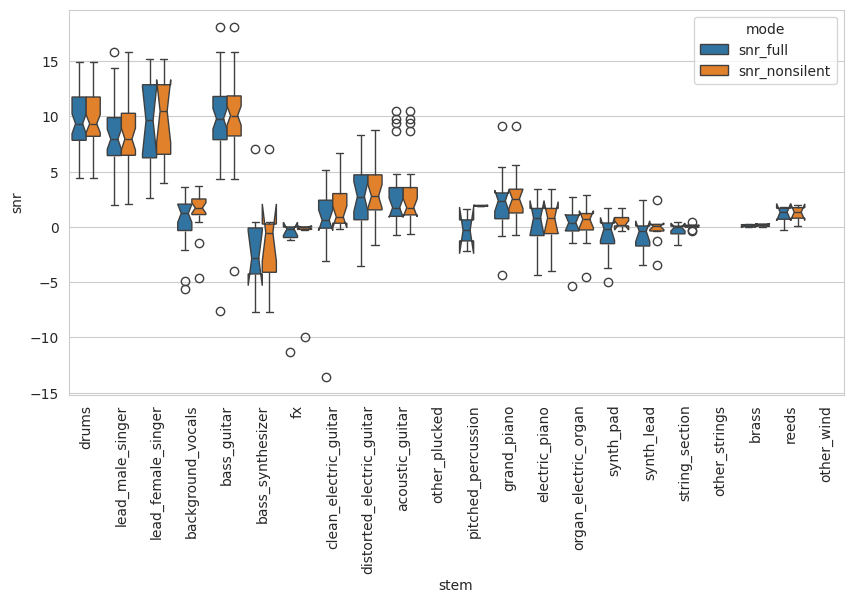

In [85]:

f, ax = plt.subplots(1, 1, figsize=(10, 5))

df_snr_by_mode = df.melt(id_vars=["song", "stem"], value_vars=["snr_full", "snr_nonsilent"], var_name="mode", value_name="snr")

df_snr_by_mode["stem"] = df_snr_by_mode["stem"].astype(allowed_instruments_dtype)

sns.boxplot(data=df_snr_by_mode, x="stem", y="snr", hue="mode", notch=True)

plt.xticks(rotation=90)

plt.show()
